In [1]:
import sys
sys.path = [p for p in sys.path if p != '']  # Remove root

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr

import hugegp_cuda as hg
import jaxkd as jk

import matplotlib.pyplot as plt
import time

key = jr.key(137)

In [3]:
def test_cov(r):
    result = (1 + (r/0.2)**2)**(-1)
    result = jnp.where(r == 0.0, result * (1 + 1e-4), result)
    return result

def test_cov_matrix(points_a, points_b=None):
    if points_b is None: points_b = points_a
    distances = jnp.expand_dims(points_a, -2) - jnp.expand_dims(points_b, -3)
    distances = jnp.linalg.norm(distances, axis=-1)
    return test_cov(distances)

In [50]:
start_time = time.time()

# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
tree = jk.build_tree(points, cuda=True)
indices = tree.indices
neighbors = hg.query_coarse_neighbors(tree, 4)
neighbors.block_until_ready()

build_time = time.time()

# Compute levels
start_level = 10
n_levels = n_points.bit_length() - 1
n_initial = 2 ** start_level - 1
level_offsets = 1 << jnp.arange(start_level, n_levels + 1, dtype=jnp.uint32)

# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

# Generate initial values
L = jnp.linalg.cholesky(test_cov_matrix(points[indices[:n_initial]]))
initial_values = L @ xi[indices[:n_initial]]

# Refine
values = hg.refine_static(
    points, xi, indices, neighbors, level_offsets, jnp.zeros(1), jnp.zeros(1), initial_values
)
values.block_until_ready()

end_time = time.time()
print(f"Build time: {1000*(build_time - start_time):.0f} ms")
print(f"Refinement time: {1000*(end_time - build_time):.0f} ms")

values

Build time: 60 ms
Refinement time: 62 ms


Array([-0.1472603 , -0.20624502, -1.2260083 , ...,  0.7433675 ,
       -0.14900269, -0.10792623], dtype=float32)

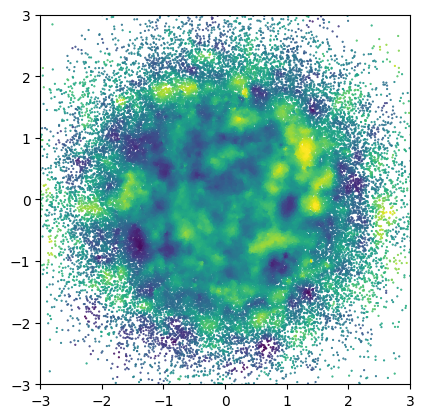

In [52]:
plt.scatter(*points.T, c=values, cmap='viridis', s=0.3, vmin=-3, vmax=3)
plt.gca().set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()